## Crypto Prediction with LSTM: Ethereum (ETH)

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- The models use a 7 day lookback window to produce series data for training and testing
- 2 optimizations were used and an overall R2 score of .90 was attained

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt


from api_keys import coinapi_key

2023-09-26 15:55:39.077259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Pull ETH data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_ETH_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-09-26T00:00:00.0000000Z', 'time_period_end': '2023-09-27T00:00:00.0000000Z', 'time_open': '2023-09-26T00:00:14.6890000Z', 'time_close': '2023-09-26T19:55:26.2990000Z', 'price_open': 1588.1, 'price_high': 1597.8, 'price_low': 1580.1, 'price_close': 1587.9, 'volume_traded': 1686.87339919, 'trades_count': 2757}, {'time_period_start': '2023-09-25T00:00:00.0000000Z', 'time_period_end': '2023-09-26T00:00:00.0000000Z', 'time_open': '2023-09-25T00:00:22.7590000Z', 'time_close': '2023-09-25T23:59:24.2430000Z', 'price_open': 1579.7, 'price_high': 1597.1, 'price_low': 1563.2, 'price_close': 1588.1, 'volume_traded': 2869.68100172, 'trades_count': 4015}, {'time_period_start': '2023-09-24T00:00:00.0000000Z', 'time_period_end': '2023-09-25T00:00:00.0000000Z', 'time_open': '2023-09-24T00:00:54.5270000Z', 'time_close': '2023-09-24T23:59:58.4620000Z', 'price_open': 1593.9, 'price_high': 1600.8, 'price_low': 1571, 'price_close': 1581, 'volume_traded': 1847.22686457, 'trades_c

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-09-26T00:00:00.0000000Z,2023-09-27T00:00:00.0000000Z,2023-09-26T00:00:14.6890000Z,2023-09-26T19:55:26.2990000Z,1588.1,1597.8,1580.1,1587.9,1686.873399,2757
1,2023-09-25T00:00:00.0000000Z,2023-09-26T00:00:00.0000000Z,2023-09-25T00:00:22.7590000Z,2023-09-25T23:59:24.2430000Z,1579.7,1597.1,1563.2,1588.1,2869.681002,4015
2,2023-09-24T00:00:00.0000000Z,2023-09-25T00:00:00.0000000Z,2023-09-24T00:00:54.5270000Z,2023-09-24T23:59:58.4620000Z,1593.9,1600.8,1571.0,1581.0,1847.226865,3090
3,2023-09-23T00:00:00.0000000Z,2023-09-24T00:00:00.0000000Z,2023-09-23T00:00:13.4860000Z,2023-09-23T23:58:57.0940000Z,1593.1,1598.0,1588.2,1594.1,723.539328,2854
4,2023-09-22T00:00:00.0000000Z,2023-09-23T00:00:00.0000000Z,2023-09-22T00:00:21.6390000Z,2023-09-22T23:59:54.9600000Z,1583.5,1601.9,1577.4,1593.2,1941.931411,4690


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2017-08-20,298.40
2017-08-21,319.31
2017-08-22,312.22
2017-08-23,315.61
2017-08-24,323.84


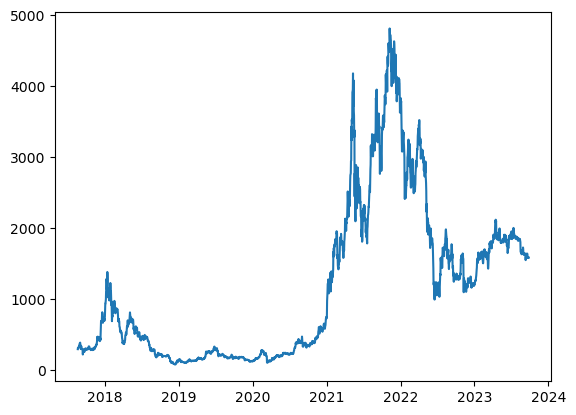

In [5]:
#plot historical eth price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 7

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

# scale to log
log_transformed_data = np.log(shifted_df_as_np)



# split y from features series
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((2212, 7), (2212,), (2212,))

In [8]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1769, 7), (1769,), (221, 7), (221,), (222, 7), (222,))

In [9]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-09-26 15:55:51.727530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
56/56 [==============================] - 6s 32ms/step - loss: 14.7545 - mean_absolute_error: 3.1255 - val_loss: 1.5474 - val_mean_absolute_error: 1.2365
Epoch 2/100
56/56 [==============================] - 1s 11ms/step - loss: 1.0183 - mean_absolute_error: 0.8607 - val_loss: 0.3870 - val_mean_absolute_error: 0.6111
Epoch 3/100
56/56 [==============================] - 1s 11ms/step - loss: 0.3310 - mean_absolute_error: 0.4495 - val_loss: 0.0033 - val_mean_absolute_error: 0.0404
Epoch 4/100
56/56 [==============================] - 1s 11ms/step - loss: 0.0077 - mean_absolute_error: 0.0662 - val_loss: 0.0052 - val_mean_absolute_error: 0.0559
Epoch 5/100
56/56 [==============================] - 1s 10ms/step - loss: 0.0059 - mean_absolute_error: 0.0572 - val_loss: 0.0040 - val_mean_absolute_error: 0.0456
Epoch 6/100
56/56 [==============================] - 1s 11ms/step - loss: 0.0061 - mean_absolute_error: 0.0595 - val_loss: 0.0043 - val_mean_absolute_error: 0.0486
Epoch 7/100
56/

Epoch 51/100
56/56 [==============================] - 0s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0547 - val_loss: 0.0034 - val_mean_absolute_error: 0.0430
Epoch 52/100
56/56 [==============================] - 0s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0520 - val_loss: 0.0171 - val_mean_absolute_error: 0.1233
Epoch 53/100
56/56 [==============================] - 0s 8ms/step - loss: 0.0069 - mean_absolute_error: 0.0644 - val_loss: 0.0027 - val_mean_absolute_error: 0.0375
Epoch 54/100
56/56 [==============================] - 0s 8ms/step - loss: 0.0050 - mean_absolute_error: 0.0523 - val_loss: 0.0025 - val_mean_absolute_error: 0.0345
Epoch 55/100
56/56 [==============================] - 0s 8ms/step - loss: 0.0047 - mean_absolute_error: 0.0499 - val_loss: 0.0025 - val_mean_absolute_error: 0.0337
Epoch 56/100
56/56 [==============================] - 0s 8ms/step - loss: 0.0043 - mean_absolute_error: 0.0482 - val_loss: 0.0045 - val_mean_absolute_error: 0.0565
Epoch 57/100
56/

56/56 [==============================] - 2s 5ms/step


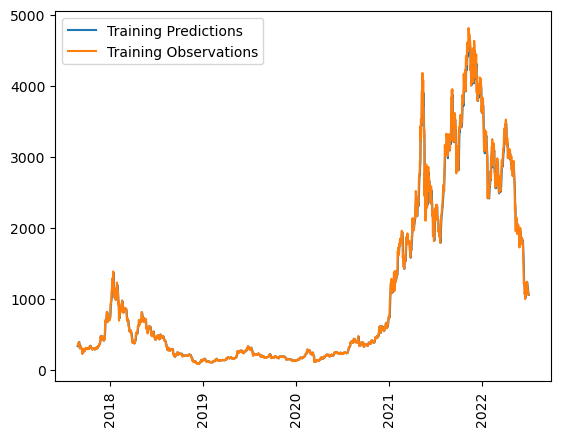

In [10]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [11]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0020100220572203398
Val MAE: 0.03061661496758461


7/7 [==============================] - 0s 6ms/step


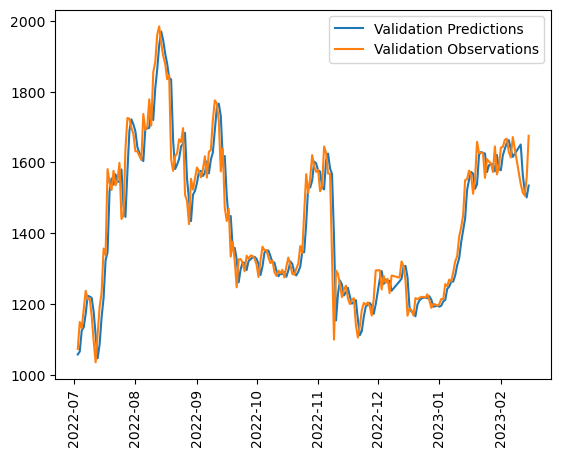

In [12]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [13]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0005282021011225879
Test MAE: 0.015762535855174065


7/7 [==============================] - 0s 6ms/step


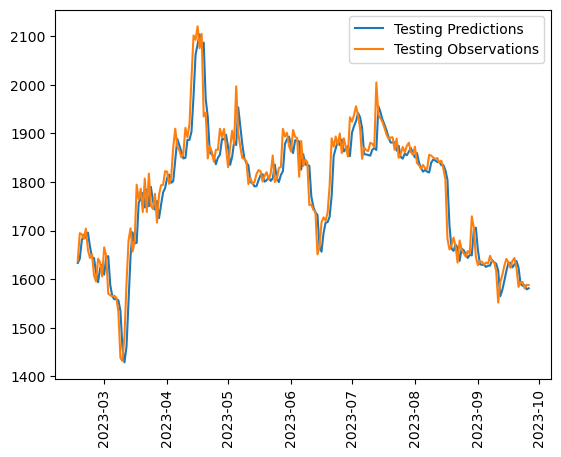

In [14]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [15]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.8990873944232135


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [16]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [17]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((862,), (862, 7), (862,), (133,), (133, 7), (133,), (111,), (111, 7), (111,))

In [18]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=200)

Epoch 1/200
27/27 [==============================] - 8s 61ms/step - loss: 54.5552 - mean_absolute_error: 7.3554 - val_loss: 51.7989 - val_mean_absolute_error: 7.1967
Epoch 2/200
27/27 [==============================] - 0s 11ms/step - loss: 50.6830 - mean_absolute_error: 7.0890 - val_loss: 48.6370 - val_mean_absolute_error: 6.9736
Epoch 3/200
27/27 [==============================] - 0s 11ms/step - loss: 47.2864 - mean_absolute_error: 6.8450 - val_loss: 44.5868 - val_mean_absolute_error: 6.6769
Epoch 4/200
27/27 [==============================] - 0s 12ms/step - loss: 42.5000 - mean_absolute_error: 6.4859 - val_loss: 38.9892 - val_mean_absolute_error: 6.2436
Epoch 5/200
27/27 [==============================] - 0s 13ms/step - loss: 36.2572 - mean_absolute_error: 5.9853 - val_loss: 32.1078 - val_mean_absolute_error: 5.6658
Epoch 6/200
27/27 [==============================] - 0s 12ms/step - loss: 28.8337 - mean_absolute_error: 5.3255 - val_loss: 24.3407 - val_mean_absolute_error: 4.9330
Epoc

27/27 [==============================] - 0s 15ms/step - loss: 0.0077 - mean_absolute_error: 0.0694 - val_loss: 0.0012 - val_mean_absolute_error: 0.0257
Epoch 51/200
27/27 [==============================] - 0s 14ms/step - loss: 0.0069 - mean_absolute_error: 0.0647 - val_loss: 0.0025 - val_mean_absolute_error: 0.0430
Epoch 52/200
27/27 [==============================] - 0s 14ms/step - loss: 0.0062 - mean_absolute_error: 0.0611 - val_loss: 0.0014 - val_mean_absolute_error: 0.0285
Epoch 53/200
27/27 [==============================] - 1s 19ms/step - loss: 0.0059 - mean_absolute_error: 0.0593 - val_loss: 0.0017 - val_mean_absolute_error: 0.0325
Epoch 54/200
27/27 [==============================] - 0s 16ms/step - loss: 0.0056 - mean_absolute_error: 0.0573 - val_loss: 0.0018 - val_mean_absolute_error: 0.0341
Epoch 55/200
27/27 [==============================] - 0s 18ms/step - loss: 0.0054 - mean_absolute_error: 0.0558 - val_loss: 0.0014 - val_mean_absolute_error: 0.0282
Epoch 56/200
27/27 [===

Epoch 100/200
27/27 [==============================] - 0s 14ms/step - loss: 0.0051 - mean_absolute_error: 0.0535 - val_loss: 0.0016 - val_mean_absolute_error: 0.0322
Epoch 101/200
27/27 [==============================] - 0s 15ms/step - loss: 0.0051 - mean_absolute_error: 0.0535 - val_loss: 0.0016 - val_mean_absolute_error: 0.0313
Epoch 102/200
27/27 [==============================] - 0s 15ms/step - loss: 0.0049 - mean_absolute_error: 0.0524 - val_loss: 0.0016 - val_mean_absolute_error: 0.0321
Epoch 103/200
27/27 [==============================] - 0s 15ms/step - loss: 0.0049 - mean_absolute_error: 0.0529 - val_loss: 0.0015 - val_mean_absolute_error: 0.0310
Epoch 104/200
27/27 [==============================] - 0s 16ms/step - loss: 0.0051 - mean_absolute_error: 0.0539 - val_loss: 0.0015 - val_mean_absolute_error: 0.0302
Epoch 105/200
27/27 [==============================] - 0s 14ms/step - loss: 0.0050 - mean_absolute_error: 0.0534 - val_loss: 0.0013 - val_mean_absolute_error: 0.0267
Epoc

27/27 [==============================] - 0s 16ms/step - loss: 0.0048 - mean_absolute_error: 0.0523 - val_loss: 0.0012 - val_mean_absolute_error: 0.0254
Epoch 150/200
27/27 [==============================] - 0s 14ms/step - loss: 0.0052 - mean_absolute_error: 0.0546 - val_loss: 0.0016 - val_mean_absolute_error: 0.0309
Epoch 151/200
27/27 [==============================] - 0s 15ms/step - loss: 0.0048 - mean_absolute_error: 0.0520 - val_loss: 0.0012 - val_mean_absolute_error: 0.0262
Epoch 152/200
27/27 [==============================] - 0s 16ms/step - loss: 0.0047 - mean_absolute_error: 0.0515 - val_loss: 0.0012 - val_mean_absolute_error: 0.0255
Epoch 153/200
27/27 [==============================] - 0s 14ms/step - loss: 0.0047 - mean_absolute_error: 0.0511 - val_loss: 0.0012 - val_mean_absolute_error: 0.0253
Epoch 154/200
27/27 [==============================] - 0s 13ms/step - loss: 0.0046 - mean_absolute_error: 0.0513 - val_loss: 0.0013 - val_mean_absolute_error: 0.0275
Epoch 155/200
27/2

27/27 [==============================] - 0s 15ms/step - loss: 0.0047 - mean_absolute_error: 0.0511 - val_loss: 0.0011 - val_mean_absolute_error: 0.0247
Epoch 199/200
27/27 [==============================] - 0s 12ms/step - loss: 0.0045 - mean_absolute_error: 0.0503 - val_loss: 0.0011 - val_mean_absolute_error: 0.0247
Epoch 200/200
27/27 [==============================] - 0s 16ms/step - loss: 0.0046 - mean_absolute_error: 0.0503 - val_loss: 0.0012 - val_mean_absolute_error: 0.0267


27/27 [==============================] - 1s 4ms/step


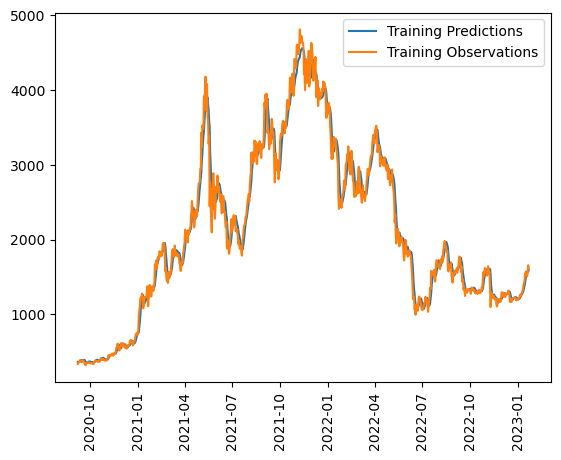

In [19]:
#Second model observations
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [20]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0012322291731834412
Val MAE: 0.026655573397874832


5/5 [==============================] - 0s 5ms/step


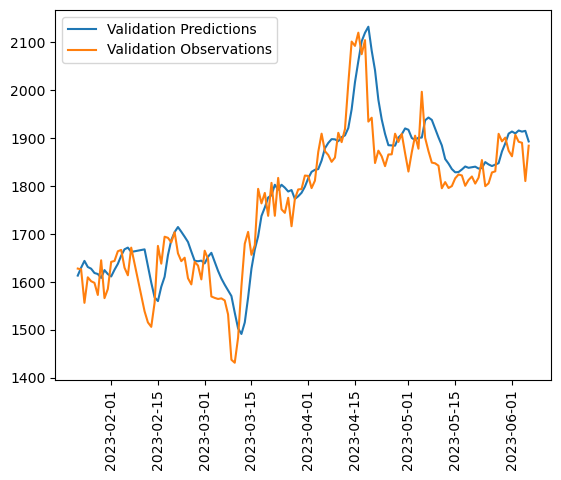

In [21]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [22]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0008323363144882023
Test MAE: 0.022653382271528244


In [23]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

4/4 [==============================] - 0s 5ms/step
R2 Score:  0.8164200528510677


4/4 [==============================] - 0s 16ms/step


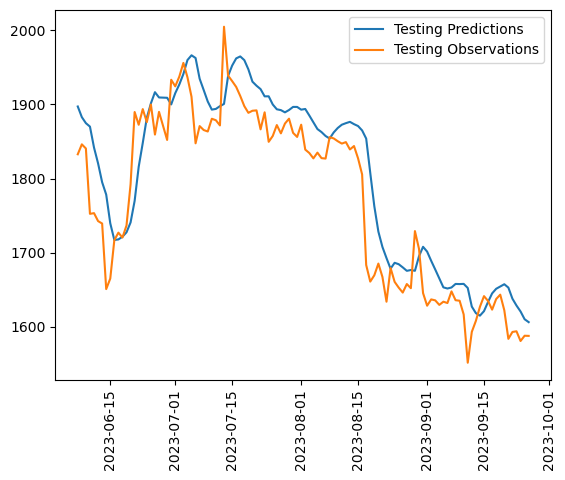

In [24]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [25]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
27/27 [==============================] - 6s 75ms/step - loss: 44.0591 - mean_absolute_error: 6.5374 - val_loss: 16.8995 - val_mean_absolute_error: 4.1101
Epoch 2/300
27/27 [==============================] - 0s 18ms/step - loss: 3.6946 - mean_absolute_error: 1.5122 - val_loss: 0.0692 - val_mean_absolute_error: 0.2503
Epoch 3/300
27/27 [==============================] - 1s 20ms/step - loss: 0.5446 - mean_absolute_error: 0.6011 - val_loss: 0.0500 - val_mean_absolute_error: 0.2089
Epoch 4/300
27/27 [==============================] - 0s 16ms/step - loss: 0.4131 - mean_absolute_error: 0.5071 - val_loss: 0.0091 - val_mean_absolute_error: 0.0722
Epoch 5/300
27/27 [==============================] - 0s 15ms/step - loss: 0.3919 - mean_absolute_error: 0.4922 - val_loss: 0.0169 - val_mean_absolute_error: 0.1101
Epoch 6/300
27/27 [==============================] - 1s 20ms/step - loss: 0.3558 - mean_absolute_error: 0.4704 - val_loss: 0.0061 - val_mean_absolute_error: 0.0667
Epoch 7/300
27

Epoch 51/300
27/27 [==============================] - 0s 15ms/step - loss: 0.0063 - mean_absolute_error: 0.0600 - val_loss: 0.0032 - val_mean_absolute_error: 0.0484
Epoch 52/300
27/27 [==============================] - 0s 16ms/step - loss: 0.0068 - mean_absolute_error: 0.0638 - val_loss: 0.0039 - val_mean_absolute_error: 0.0545
Epoch 53/300
27/27 [==============================] - 0s 17ms/step - loss: 0.0075 - mean_absolute_error: 0.0674 - val_loss: 0.0047 - val_mean_absolute_error: 0.0605
Epoch 54/300
27/27 [==============================] - 0s 13ms/step - loss: 0.0069 - mean_absolute_error: 0.0635 - val_loss: 0.0015 - val_mean_absolute_error: 0.0292
Epoch 55/300
27/27 [==============================] - 1s 20ms/step - loss: 0.0070 - mean_absolute_error: 0.0635 - val_loss: 0.0014 - val_mean_absolute_error: 0.0285
Epoch 56/300
27/27 [==============================] - 1s 28ms/step - loss: 0.0061 - mean_absolute_error: 0.0595 - val_loss: 0.0013 - val_mean_absolute_error: 0.0271
Epoch 57/3

Epoch 101/300
27/27 [==============================] - 0s 16ms/step - loss: 0.0054 - mean_absolute_error: 0.0563 - val_loss: 0.0025 - val_mean_absolute_error: 0.0434
Epoch 102/300
27/27 [==============================] - 0s 14ms/step - loss: 0.0074 - mean_absolute_error: 0.0667 - val_loss: 0.0112 - val_mean_absolute_error: 0.1006
Epoch 103/300
27/27 [==============================] - 0s 15ms/step - loss: 0.0083 - mean_absolute_error: 0.0721 - val_loss: 0.0024 - val_mean_absolute_error: 0.0419
Epoch 104/300
27/27 [==============================] - 0s 16ms/step - loss: 0.0054 - mean_absolute_error: 0.0575 - val_loss: 0.0016 - val_mean_absolute_error: 0.0315
Epoch 105/300
27/27 [==============================] - 0s 15ms/step - loss: 0.0051 - mean_absolute_error: 0.0549 - val_loss: 0.0019 - val_mean_absolute_error: 0.0360
Epoch 106/300
27/27 [==============================] - 0s 13ms/step - loss: 0.0049 - mean_absolute_error: 0.0536 - val_loss: 0.0021 - val_mean_absolute_error: 0.0377
Epoc

27/27 [==============================] - 0s 13ms/step - loss: 0.0043 - mean_absolute_error: 0.0500 - val_loss: 9.9770e-04 - val_mean_absolute_error: 0.0237
Epoch 151/300
27/27 [==============================] - 0s 18ms/step - loss: 0.0064 - mean_absolute_error: 0.0633 - val_loss: 0.0013 - val_mean_absolute_error: 0.0286
Epoch 152/300
27/27 [==============================] - 0s 14ms/step - loss: 0.0045 - mean_absolute_error: 0.0515 - val_loss: 0.0019 - val_mean_absolute_error: 0.0365
Epoch 153/300
27/27 [==============================] - 0s 14ms/step - loss: 0.0039 - mean_absolute_error: 0.0472 - val_loss: 8.7416e-04 - val_mean_absolute_error: 0.0218
Epoch 154/300
27/27 [==============================] - 0s 15ms/step - loss: 0.0048 - mean_absolute_error: 0.0535 - val_loss: 0.0054 - val_mean_absolute_error: 0.0680
Epoch 155/300
27/27 [==============================] - 0s 15ms/step - loss: 0.0045 - mean_absolute_error: 0.0524 - val_loss: 0.0011 - val_mean_absolute_error: 0.0256
Epoch 156/

27/27 [==============================] - 0s 17ms/step - loss: 0.0035 - mean_absolute_error: 0.0458 - val_loss: 8.8671e-04 - val_mean_absolute_error: 0.0228
Epoch 200/300
27/27 [==============================] - 0s 15ms/step - loss: 0.0037 - mean_absolute_error: 0.0467 - val_loss: 0.0012 - val_mean_absolute_error: 0.0266
Epoch 201/300
27/27 [==============================] - 0s 13ms/step - loss: 0.0031 - mean_absolute_error: 0.0418 - val_loss: 7.6454e-04 - val_mean_absolute_error: 0.0203
Epoch 202/300
27/27 [==============================] - 0s 14ms/step - loss: 0.0032 - mean_absolute_error: 0.0421 - val_loss: 0.0012 - val_mean_absolute_error: 0.0264
Epoch 203/300
27/27 [==============================] - 0s 15ms/step - loss: 0.0044 - mean_absolute_error: 0.0519 - val_loss: 0.0023 - val_mean_absolute_error: 0.0425
Epoch 204/300
27/27 [==============================] - 0s 13ms/step - loss: 0.0038 - mean_absolute_error: 0.0465 - val_loss: 0.0020 - val_mean_absolute_error: 0.0376
Epoch 205/

Epoch 248/300
27/27 [==============================] - 0s 18ms/step - loss: 0.0030 - mean_absolute_error: 0.0408 - val_loss: 8.9095e-04 - val_mean_absolute_error: 0.0226
Epoch 249/300
27/27 [==============================] - 0s 17ms/step - loss: 0.0035 - mean_absolute_error: 0.0452 - val_loss: 0.0013 - val_mean_absolute_error: 0.0292
Epoch 250/300
27/27 [==============================] - 1s 22ms/step - loss: 0.0034 - mean_absolute_error: 0.0446 - val_loss: 7.2891e-04 - val_mean_absolute_error: 0.0196
Epoch 251/300
27/27 [==============================] - 0s 15ms/step - loss: 0.0035 - mean_absolute_error: 0.0452 - val_loss: 0.0034 - val_mean_absolute_error: 0.0533
Epoch 252/300
27/27 [==============================] - 0s 17ms/step - loss: 0.0037 - mean_absolute_error: 0.0474 - val_loss: 8.1539e-04 - val_mean_absolute_error: 0.0222
Epoch 253/300
27/27 [==============================] - 0s 13ms/step - loss: 0.0033 - mean_absolute_error: 0.0436 - val_loss: 7.2488e-04 - val_mean_absolute_er

Epoch 297/300
27/27 [==============================] - 0s 15ms/step - loss: 0.0037 - mean_absolute_error: 0.0478 - val_loss: 8.3618e-04 - val_mean_absolute_error: 0.0217
Epoch 298/300
27/27 [==============================] - 0s 14ms/step - loss: 0.0028 - mean_absolute_error: 0.0393 - val_loss: 7.3487e-04 - val_mean_absolute_error: 0.0197
Epoch 299/300
27/27 [==============================] - 0s 15ms/step - loss: 0.0028 - mean_absolute_error: 0.0392 - val_loss: 7.3294e-04 - val_mean_absolute_error: 0.0197
Epoch 300/300
27/27 [==============================] - 0s 15ms/step - loss: 0.0045 - mean_absolute_error: 0.0519 - val_loss: 0.0129 - val_mean_absolute_error: 0.1103


27/27 [==============================] - 2s 6ms/step


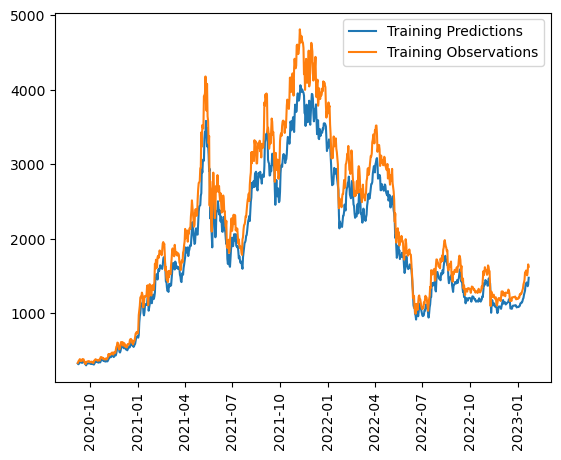

In [26]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [27]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0128838075324893
Val MAE: 0.11032679677009583


5/5 [==============================] - 0s 8ms/step


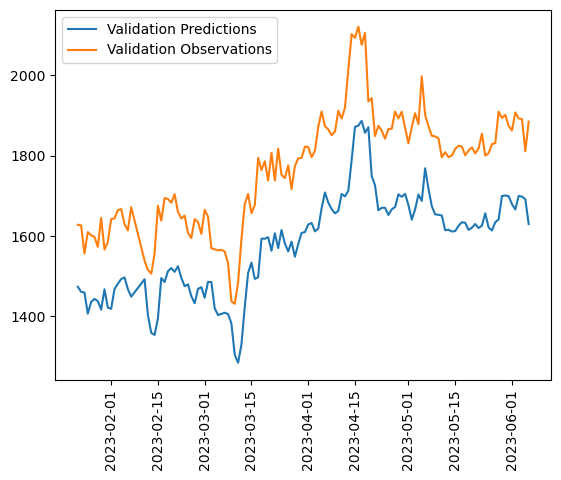

In [28]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [29]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.011978326365351677
Test MAE: 0.10787223279476166


4/4 [==============================] - 0s 11ms/step


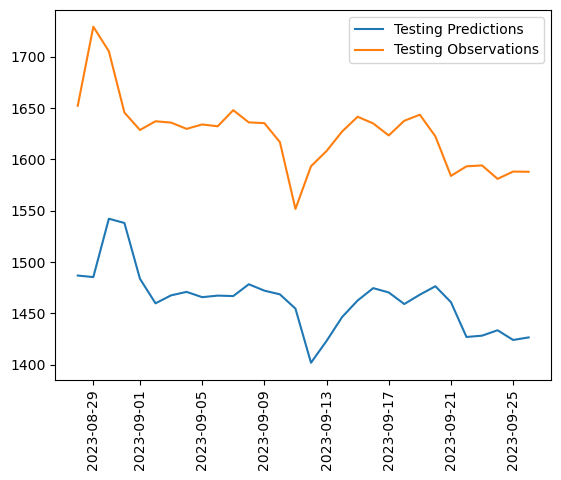

In [30]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2[-30:], np.exp(test_predictions3[-30:]))
plt.plot(dates_test2[-30:],np.exp(y_test2[-30:]))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [31]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  -1.6419342129385615


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends
- We are using the best scoring model for testing predictions

In [32]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7
#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test2[-1]
current_reshape = current_batch.reshape((1, lookback, 1))
initial_date = dates_test2[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model3.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback, 1))

#Adding future dates at the end of the dateset   
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 100ms/step
[7.2630153, 7.242645, 7.2455616, 7.250406, 7.251275, 7.250184, 7.249244]
2023-09-27
2023-09-28
2023-09-29
2023-09-30
2023-10-01
2023-10-02
2023-10-03


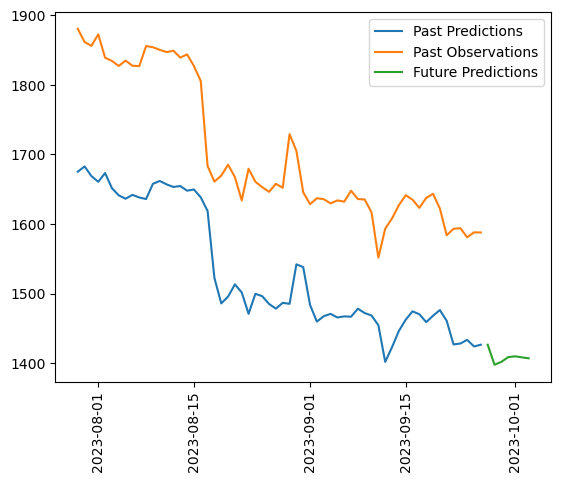

In [33]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions3[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [34]:
# Export model to HDF5 file
model.save("H5_Files/eth_7_day_1.h5")

In [35]:
# Export model to HDF5 file
model2.save("H5_Files/eth_7_day_2.h5")

In [36]:
# Export model to HDF5 file
model3.save("H5_Files/eth_7_day_3.h5")

In [37]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)


df

,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-06-29,1852.1,1873.908813,1908.985229,1685.040649
2023-06-30,1933.3,1853.346680,1900.007202,1663.591553
2023-07-01,1924.4,1901.479248,1915.247070,1717.364136
2023-07-02,1937.6,1914.793213,1926.931152,1726.892944
2023-07-03,1956.0,1925.582764,1941.084473,1731.318115
...,...,...,...,...
2023-09-22,1593.2,1590.315186,1638.062378,1426.969849
2023-09-23,1594.1,1586.255737,1628.825684,1428.246216
2023-09-24,1581.0,1587.640503,1620.816895,1433.512207


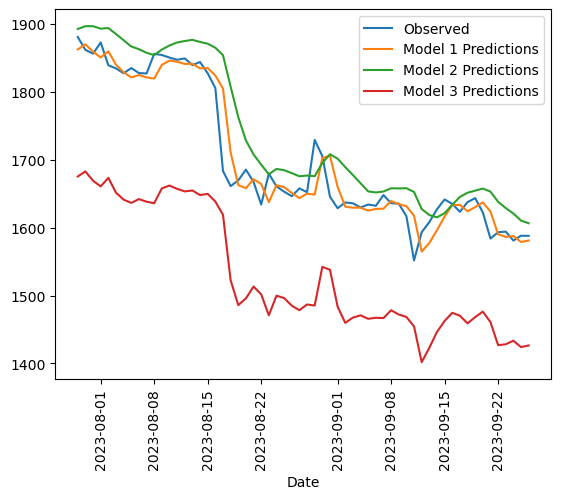

In [38]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [39]:
#output prediction data to csv
df.to_csv('output/eth_predict.csv') 

In [40]:
#output original historical data to csv
data.to_csv('output/eth_lifetime.csv')

In [41]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  0.8990873944232135
Model 2 R2 Score:  0.8164200528510677
Model 3 R2 Score:  -1.6419342129385615
